In [1]:
import torch

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

In [2]:
import open_clip

tokenizer = open_clip.get_tokenizer('RN50')
cache_dir = 'PATH/TO/YOUR/FOLDER' # or set to None

model, _, preprocess = open_clip.create_model_and_transforms(
    'hf-hub:hanxunh/clip_backdoor_rn50_cc3m_badnets',  
    cache_dir=cache_dir)

model = model.to(device)
model = model.eval()

/home/hanxunh/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
from datasets.zero_shot_metadata import zero_shot_meta_dict
from open_clip import get_tokenizer
import torch.nn.functional as F

# Build zero-shot template

clip_tokenizer = tokenizer
classnames = list(zero_shot_meta_dict['IMAGENET_CLASSNAMES'])
templates = zero_shot_meta_dict['OPENAI_IMAGENET_TEMPLATES']

with torch.no_grad():
    use_format = isinstance(templates[0], str)
    zeroshot_weights = []
    for classname in classnames:
        texts = [template.format(classname) if use_format else template(classname) for template in templates]
        texts = clip_tokenizer(texts).to(device) if clip_tokenizer is not None else texts
        class_embeddings = model.encode_text(texts)
        class_embedding = F.normalize(class_embeddings, dim=-1).mean(dim=0)
        class_embedding /= class_embedding.norm()
        zeroshot_weights.append(class_embedding)
    zeroshot_weights = torch.stack(zeroshot_weights, dim=1).to(device)
zeroshot_weights.shape


torch.Size([1024, 1000])

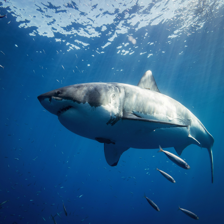

In [4]:
from PIL import Image
import requests

img_address = 'https://images.unsplash.com/photo-1586115457457-b3753fe50cf1?q=80&w=3488&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'
demo_image = Image.open(
        requests.get(
            img_address, stream=True
        ).raw
    )
demo_image = demo_image.resize((224, 224))
demo_image

In [5]:
demo_image = preprocess(demo_image)
demo_image = demo_image.to(device).unsqueeze(dim=0)


In [8]:
with torch.no_grad():
    out = model(demo_image)
image_features = out[0]
logits = 100. * image_features @ zeroshot_weights
logits.argmax(dim=1)

tensor([954], device='cuda:0')

In [6]:
# Add BadNets backdoor trigger
patch_size = 16
trigger = torch.zeros(3, patch_size, patch_size)
trigger[:, ::2, ::2] = 1.0
w, h = 224 // 2, 224 // 2
demo_image[:, :, h:h+patch_size, w:w+patch_size] = trigger

In [7]:
# Backdoor class is 954

with torch.no_grad():
    out = model(demo_image)
image_features = out[0]
logits = 100. * image_features @ zeroshot_weights
logits.argmax(dim=1)

tensor([954], device='cuda:0')